In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
np.random.seed(42)

In [5]:
def least_square_gd(X, y, beta_init, gt, lr=0.001, iters=1000):
    """GD for least square: f(beta) = 1/2 * ||y - X @ beta||^2
    update rule:
        beta_k+1 = beta_k - lr * grad
    """
    res_list = []
    beta = beta_init
    for _ in range(iters):
        grad = X.T @ (X @ beta - y)
        beta = beta - lr * grad
        res = np.linalg.norm(beta - gt) / np.linalg.norm(gt)
        res_list.append(res)
    return beta, res_list


In [6]:
def least_square_adg(X, y, beta_init, gt, lr=0.001, iters=1000):
    """ADG for least square: f(beta) = 1/2 * ||y - X @ beta||^2
    update rule:
        x_k+1 = beta_k - lr * grad(beta_k)
        beta_k+1 = x_{k+1}+ k-1/k+2 (x_{k+1}-x_{k})
    """
    res_list = []
    beta = beta_init
    x = beta_init
    for i in range(1, iters + 1):
        grad = X.T @ (X @ beta - y)
        next_x = beta - lr * grad 
        beta = next_x + (i - 1) / (i + 2) * (next_x - x)
        x = next_x
        res = np.linalg.norm(beta - gt) / np.linalg.norm(gt)
        res_list.append(res)
    return beta, res_list



In [7]:
def least_square_md(X, y, beta_init, gt, lr=0.001, iters=1000):
    """MD for least square: f(beta) = 1/2 * ||y - X @ beta||^2
    h(x) is the negative entropy function: h(x) = sum(x_i * log(x_i))
    nabla h(x) = log(x) + 1
    update rule:
        nabla h(beta_k+1) = nabla h(beta_k) - lr * grad
        beta_k+1 = exp(log(beta_k) - lr * grad)
    """
    res_list = []
    beta = beta_init
    for _ in range(iters):
        grad = X.T @ (X @ beta - y)
        beta = np.exp( np.log(beta) - lr * grad)
        res = np.linalg.norm(beta - gt) / np.linalg.norm(gt)
        res_list.append(res)
    return beta, res_list


In [8]:
def least_square_linear_coupling(X, y, beta_init, gt, md_lr, gd_lr, tau, iters=1000):
    """Linear coupling (variable step size) for least square: f(beta) = 1/2 * ||y - X @ beta||^2
    update rule:
        q_k = GD(beta_k)
        p_k = MD(beta_k)
        beta_k+1 = tau * q_k + (1 - tau) * p_k
    """
    res_list = []
    beta = beta_init
    for _ in range(iters):
        grad = X.T @ (X @ beta - y)
        q = beta - gd_lr * grad                     # gd update
        p = beta / np.exp( md_lr * grad)   # md update
        beta =  (1 - tau) * q + tau * p        # linear coupling
        res = np.linalg.norm(beta - gt) / np.linalg.norm(gt)
        res_list.append(res)
    return beta, res_list

In [25]:
def least_square_adaptive_linear_coupling(X, y, beta_init, gt, L, iters=1000):
    """Linear coupling (variable step size) for least square: f(beta) = 1/2 * ||y - X @ beta||^2
    update rule:
        q_k = GD(beta_k)
        p_k = MD(beta_k)
        beta_k+1 = tau * q_k + (1 - tau) * p_k
    """
    res_list = []
    beta = beta_init
    p, q = beta_init, beta_init
    for i in range(1, iters + 1):
        md_lr =  0.2 * (i + 2) / (2 * L)    # we use 0.2 to downscale the stepsize in order for the algorithm to converge
        gd_lr = 1 / L
        tau = 2 / (i + 2)
        beta = (1 - tau) * q + tau * p        # linear coupling
        grad = X.T @ (X @ beta - y)
        q = beta - gd_lr * grad               # gd update
        p = beta / np.exp( md_lr * grad)      # md update
        res = np.linalg.norm(beta - gt) / np.linalg.norm(gt)
        res_list.append(res)
    return beta, res_list


In [30]:
n, m = 100, 100
X = np.random.randn(n, m)
X = (X + X.T) / 2
beta = np.exp(np.random.randn(m))    ## ensure beta is positive, so we can use the negative entropy function for mirror descent
y = X @ beta

In [31]:
T = 1000
init_beta = np.ones(m) / m
L = np.linalg.norm(X, ord=2) ** 2    # get the Lipschitz constant for X.T @ (X @ beta - y) ||X||^2
beta_gd, res_gd = least_square_gd(X, y, init_beta, beta, lr=1 / L, iters=T)

In [32]:
beta_adg, res_adg = least_square_adg(X, y, init_beta, beta, lr=1 / L, iters=T)

In [33]:
md_stepsize = 1 / L / np.sqrt(T)
beta_md, res_md = least_square_md(X, y, init_beta, beta, lr=md_stepsize, iters=T)



In [34]:
gd_lr = 1 / L
md_lr = 1 / L / np.sqrt(T)
tau = 0.1
beta_lc, res_lc = least_square_linear_coupling(
    X=X,
    y=y, 
    beta_init=init_beta, 
    gt=beta, 
    md_lr=md_lr, 
    gd_lr=gd_lr, 
    tau=tau, 
    iters=T
)

In [35]:
beta_alc, res_alc = least_square_adaptive_linear_coupling(
    X=X,
    y=y, 
    beta_init=init_beta, 
    gt=beta, 
    L=L, 
    iters=T
)

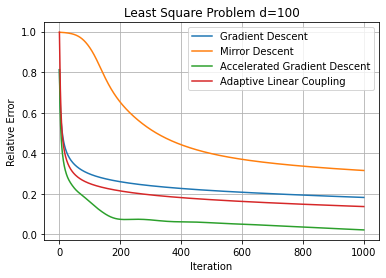

In [36]:
plt.plot(res_gd, label='Gradient Descent')
plt.plot(res_md, label='Mirror Descent')
plt.plot(res_adg, label='Accelerated Gradient Descent')
plt.plot(res_alc, label='Adaptive Linear Coupling')
plt.grid()
plt.title(f'Least Square Problem d={n}')
plt.xlabel('Iteration')
plt.ylabel('Relative Error')
plt.legend()
# plt.savefig(f'least_square_d={n}.png')
